# Анализ А/В-теста

### Данные, с которыми работаем:
Мы работаем с логом событий, совершенных пользователями мобильного приложения интернет-магазина.

### Задачи проекта
 -  изучить поведение пользователей мобильного приложения.
 -  исследовать результаты A/A/B-эксперимента

## План проекта

1. [Шаг 1. Изучение общей информации](#step1)  
2. [Шаг 2. Подготовка данных](#step2) 
3. [Шаг 3. Изучение данных](#step3) 
4. [Шаг 4. Изучение воронки событий ](#step4) 
5. [Шаг 5. Изучение результатов эксперимента](#step5) 
6. [Шаг 6. Общий вывод](#step6) 

## Шаг 1. Изучение общей информации <a id="step1"></a>

Импортируем все необходимые библиотеки. Затем изучим датасет методами info() и sample().

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.dates
import math as mth
import datetime as dt
import seaborn as sns
import numpy as np
from pymystem3 import Mystem 
m = Mystem()
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
from matplotlib.ticker import MaxNLocator
import math
from scipy.stats import ttest_ind
from scipy import stats as st
from IPython.display import display

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
data.sample(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
11347,MainScreenAppear,886657000547237550,1564650152,246
131559,MainScreenAppear,8118035828955742702,1564934521,248
24260,OffersScreenAppear,8814344554182113389,1564670029,248
21362,MainScreenAppear,7935558698316724759,1564666126,247
147938,MainScreenAppear,3950621044918665658,1564993058,248


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропусков в данных нет. Формат времени нужно изменить - сделаем это на следующем шаге. Также изменим тип данных в столбце с группами - сделаем их строкой.

## Шаг 2. Подготовка данных <a id="step2"></a>

Заменим названия столбцов на более удобные.

In [5]:
data.columns = ['event', 'id', 'timestamp', 'group']

Также заменим названия групп на А, А1 и В.

In [6]:
data['group'] = data['group'].astype('str')
data['group'] = data['group'].str.replace('246', 'A')
data['group'] = data['group'].str.replace('247', 'A1')
data['group'] = data['group'].str.replace('248', 'B')
data

,event,id,timestamp,group
0,MainScreenAppear,4575588528974610257,1564029816,A
1,MainScreenAppear,7416695313311560658,1564053102,A
2,PaymentScreenSuccessful,3518123091307005509,1564054127,B
3,CartScreenAppear,3518123091307005509,1564054127,B
4,PaymentScreenSuccessful,6217807653094995999,1564055322,B
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,A1
244122,MainScreenAppear,5849806612437486590,1565212439,A
244123,MainScreenAppear,5746969938801999050,1565212483,A
244124,MainScreenAppear,5746969938801999050,1565212498,A


Удалим полностью дублирующиеся строки.

In [7]:
data.drop_duplicates()

,event,id,timestamp,group
0,MainScreenAppear,4575588528974610257,1564029816,A
1,MainScreenAppear,7416695313311560658,1564053102,A
2,PaymentScreenSuccessful,3518123091307005509,1564054127,B
3,CartScreenAppear,3518123091307005509,1564054127,B
4,PaymentScreenSuccessful,6217807653094995999,1564055322,B
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,A1
244122,MainScreenAppear,5849806612437486590,1565212439,A
244123,MainScreenAppear,5746969938801999050,1565212483,A
244124,MainScreenAppear,5746969938801999050,1565212498,A


Добавим столбцы с датой и временем, а также столбец с датой.

In [8]:
data['datetime'] = pd.to_datetime(data['timestamp'], unit='s')
data['date'] = data['datetime'].dt.date
data

,event,id,timestamp,group,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,A,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,A,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,B,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,A1,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,A,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,A,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,A,2019-08-07 21:14:58,2019-08-07


Данные подготовлены, можем переходить к изучению воронки.

## Шаг 3. Изучение данных <a id="step3"></a>

Посмотрим, сколько всего событий в логе.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
event        244126 non-null object
id           244126 non-null int64
timestamp    244126 non-null int64
group        244126 non-null object
datetime     244126 non-null datetime64[ns]
date         244126 non-null object
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 11.2+ MB


Всего в логе 244126 событий.

Посчитаем количество пользователей в логе.

In [10]:
data['id'].nunique()

7551

В логе 7551 пользователь.

Посмотрим, сколько в среднем событий приходится на пользователя.

In [11]:
data.groupby('id')['event'].count().reset_index().describe()


,id,event
count,7.551000e+03,7551.000000
mean,4.677319e+18,32.330287
std,2.655343e+18,65.312344
min,6.888747e+15,1.000000
25%,2.397700e+18,9.000000
50%,4.688022e+18,20.000000
75%,7.007353e+18,37.500000
max,9.222603e+18,2308.000000


В среднем на одного пользователя приходится 32 события, если считать по среднему арифметичсекому и 20 событий, если считать по медиане.

Изучим период времени, которым мы располагаем.

In [12]:
data['date'].sort_values()

0         2019-07-25
1         2019-07-25
2         2019-07-25
3         2019-07-25
4         2019-07-25
             ...    
223356    2019-08-07
223355    2019-08-07
223354    2019-08-07
223382    2019-08-07
244125    2019-08-07
Name: date, Length: 244126, dtype: object

Минимальная дата - 2019-07-25, максимальная дата - 2019-08-07

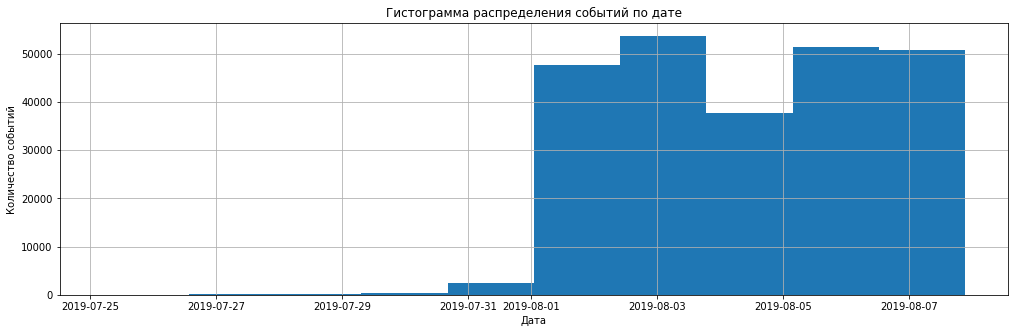

In [13]:
ax = data['datetime'].hist(figsize=(17,5))
ax.set_title('Гистограмма распределения событий по дате')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество событий');

Мы видим, что на самом деле мы располагаем данными с 2019-08-01 по 2019-08-07, то есть данными за неделю. Отбросим остальные данные.

In [14]:
data['date'] = pd.to_datetime(data['date'])

In [15]:
data = data[data['date'] >= '2019-08-01']

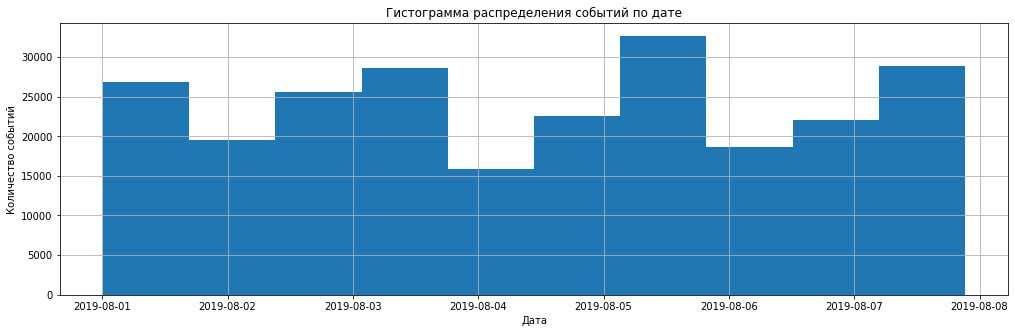

In [16]:
ax = data['datetime'].hist(figsize=(17,5))
ax.set_title('Гистограмма распределения событий по дате')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество событий');

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241298 entries, 2828 to 244125
Data columns (total 6 columns):
event        241298 non-null object
id           241298 non-null int64
timestamp    241298 non-null int64
group        241298 non-null object
datetime     241298 non-null datetime64[ns]
date         241298 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 12.9+ MB


У нас осталось 241298 событий. почти 3000 событий мы вырезали

Посчитаем количество уникальных пользователей в преобразованном датафрейме.

In [18]:
data['id'].nunique()

7534

Осталось 7534 пользователя, было - 7551. Значит, при очистке датафрейма мы потеряли 17 пользователей.

Посмотрим, пользователи всех ли групп остались после преобразования.

In [19]:
data['group'].value_counts()

B     84726
A     79425
A1    77147
Name: group, dtype: int64

У нас остались пользователи из всех трех групп.

## Вывод Шага 3.

1. Всего в логе 244126 событий.
2. В логе 7551 пользователь.
3. В среднем на одного пользователя приходится 32 события, если считать по среднему арифметичсекому и 20 событий, если считать по медиане.
4. Мы располагаем данными с 2019-08-01 по 2019-08-07, то есть данными за неделю

## Шаг 4. Изучение воронки событий <a id="step4"></a>

- Посмотрим, какие события есть в логах, как часто они встречаются.

In [20]:
data['event'].value_counts()

MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: event, dtype: int64

Мы получили отсортированную по убыванию таблицу с частотой каждого события. Как мы видим, чаще всего пользователи открывают главный экран, реже всего - туториал.

- Посчитаем, сколько пользователей совершали каждое из этих событий.

In [21]:
idGroupedByEvent = data.groupby('event')['id'].nunique().sort_values(ascending=False).reset_index()
idGroupedByEvent

,event,id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Мы видим, что число уникальных пользователей для каждого события у нас меньше, чем частота события. Это значит, что пользователи совершают событие по несолько раз.

 - Посчитаем долю пользователей, которые хоть раз совершали событие. Добавим колонку с долей в датафрейм с количеством уникальных пользователей, сгруппированных по событиям.

In [22]:
idGroupedByEvent['rate'] = idGroupedByEvent['id'] / data['id'].nunique()
idGroupedByEvent

,event,id,rate
0,MainScreenAppear,7419,0.984736
1,OffersScreenAppear,4593,0.609636
2,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


Мы видим, что:
- 98% пользователей открывают главную страницу
- 61% пользователей открывают страницу с товарами
- 50% пользователей открывают страницу с корзиной
- 47% пользователей доходят до страницы оплаты
- 11% пользователей просматривают туториал.


Отсюда можно извлечь следующие выводы:

- почти 40% посетителей покидают приложение после просмотра главной страницы. Возможно, стоит изучить эту проблему подробнее: почему они это делают? Возможно, кнопка с переходом на страницу с товарами расположена незаметно? Либо есть какие-то другие проблемы?
- между корзиной и формой оплаты мы теряем 3% пользователей. Эту проблему тоже, возможно, необходимо рассмотреть глубже.
- только 11% пользователей просматривают туториал. С одной стороны, это можно объяснить тем, что люди не любят читать инструкции. С другой стороны, возможно, стоит сделать переход на страницу с туториалом более заметным.

- Рассмотрим, в каком порядке происходят события.

Предположительно, события происходят в порядке:
    
    
MainScreenAppear           
OffersScreenAppear         
CartScreenAppear           
PaymentScreenSuccessful    


Событие **tutorial** может произойти на любом этапе цепочки событий, поэтому его не будем учитывать при расчете воронки.

- По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

Добавим пустой столбец с воронокой в таблицу idGroupedByEvent.

In [23]:
idGroupedByEvent['funnel'] = np.nan
idGroupedByEvent

,event,id,rate,funnel
0,MainScreenAppear,7419,0.984736,NaN
1,OffersScreenAppear,4593,0.609636,NaN
2,CartScreenAppear,3734,0.495620,NaN
3,PaymentScreenSuccessful,3539,0.469737,NaN
4,Tutorial,840,0.111495,NaN


Заполним его значениями доли пользователей, которые переходят с одного на следующий шаг воронки.

In [24]:
idGroupedByEvent.loc[0, 'funnel'] = 1
idGroupedByEvent.loc[1, 'funnel'] = idGroupedByEvent.loc[1, 'rate'] / idGroupedByEvent.loc[0, 'rate']
idGroupedByEvent.loc[2, 'funnel'] = idGroupedByEvent.loc[2, 'rate'] / idGroupedByEvent.loc[1, 'rate']
idGroupedByEvent.loc[3, 'funnel'] = idGroupedByEvent.loc[3, 'rate'] / idGroupedByEvent.loc[2, 'rate']
idGroupedByEvent['funnel'] = idGroupedByEvent['funnel'].round(2)
idGroupedByEvent

,event,id,rate,funnel
0,MainScreenAppear,7419,0.984736,1.00
1,OffersScreenAppear,4593,0.609636,0.62
2,CartScreenAppear,3734,0.495620,0.81
3,PaymentScreenSuccessful,3539,0.469737,0.95
4,Tutorial,840,0.111495,NaN


Мы видим, что больше всего пользователей теряем на этапе просмотра экрана с предложением - только 62% пользователей переходят на эту страницу с главного экрана.

- Какая доля пользователей доходит от первого события до оплаты?

In [25]:
idGroupedByEvent.loc[3, 'rate'] / idGroupedByEvent.loc[0, 'rate']

0.4770184661005526

От первого события до оплаты доходит 48% пользователей.

## Выводы Шага 4:

- 98% пользователей открывают главную страницу
- 61% пользователей открывают страницу с товарами
- 50% пользователей открывают страницу с корзиной
- 47% пользователей доходят до страницы оплаты
- 11% пользователей просматривают туториал
- больше всего пользователей теряем на этапе просмотра экрана с предложением - только 62% пользователей переходят на эту страницу с главного экрана
- от первого события до оплаты доходит 48% пользователей.

## Шаг 5. Изучение результатов эксперимента <a id="step5"></a>

- Посчитаем, сколько пользователей в каждой экспериментальной группе.

In [26]:
idGroupedByGroup = data.groupby('group')['id'].nunique().reset_index()
idGroupedByGroup

,group,id
0,A,2484
1,A1,2513
2,B,2537


Получили таблицу с количеством уникальных пользователей по группам.

- Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

 - Создадим таблицу с распределением числа пользователей, совершивших каждое событие в каждой из контрольных групп.

In [27]:
gpoupsGroupedByEvent = (data.pivot_table(index='event', columns = 'group', values='id', aggfunc=pd.Series.nunique)
       .reset_index())
gpoupsGroupedByEvent.columns = ['event', 'A', 'A1', 'B']

gpoupsGroupedByEvent = gpoupsGroupedByEvent.sort_values(by='A', ascending=False).reset_index(drop=True)
gpoupsGroupedByEvent

,event,A,A1,B
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


Посчитаем число пользователей, совершивших событие **MainScreenAppear** в каждой из контрольных групп.

In [28]:
gpoupsGroupedByEvent.loc[0, 'A'] / idGroupedByGroup.loc[0, 'id']

0.9863123993558777

In [29]:
gpoupsGroupedByEvent.loc[0, 'A1'] / idGroupedByGroup.loc[1, 'id']

0.9852765618782332

Мы видим, что доли не равны - есть небольшая разница. Проверим, будет ли отличие между группами статистически достоверным. Проверим гипотезу для равенства долей. Сформулируем гипотезы:

H0: между долями есть значимая разница


Н1: между долями не значимой разницы

Критическим уровнем статистической значимости альфа выберем 0.05. Далее мы будем проводить 4 эксперимента для контрольных групп и 12 экспериментов для контрольных и экспериментальных групп. Соответственно, сделаем поправку уровня альфа для множественной проверки гипотез, где для экспериментов с контрольными группами m=4, для экспериментов с контрольными и экспериментальными группами m=12. Используем метод Бонферрони, то есть скорректированное значение альфа будет равно значению альфа, деленному на количество гипотез. Значит, альфа для экспериментов с контрольными группами будет равно 0.05/4 = 0.0125, для экспериментов с контрольными и экспериментальными группами - 0.05/12 = 0.0042

In [30]:
alpha = .05

p1 = gpoupsGroupedByEvent.loc[0, 'A']/idGroupedByGroup.loc[0, 'id']
p2 = gpoupsGroupedByEvent.loc[0, 'A1']/idGroupedByGroup.loc[1, 'id']

p_combined = ((gpoupsGroupedByEvent.loc[0, 'A'] + gpoupsGroupedByEvent.loc[0, 'A1']) 
              / (idGroupedByGroup.loc[0, 'id'] + idGroupedByGroup.loc[1, 'id']))

difference = p1 - p2

z_value = (difference 
     / mth.sqrt(p_combined * (1-p_combined) * (1/idGroupedByGroup.loc[0, 'id'] + 1/idGroupedByGroup.loc[1, 'id'])))

distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


У нас не получилось отвергнуть гипотезу о том, что между долями пользователей групп А и А1, перешедших на главную страницу есть отличие.

Создадим функцию, с помощью которой проверим гипотезу о равенстве долей для каждой группы и каждого события. 

In [31]:
def hypothesis(group1, group2, numberOfStrWithIdInGroup1, numberOfStrWithIdInGroup2, numberOfStrWithEvent, alpha):
    p1 = gpoupsGroupedByEvent.loc[numberOfStrWithEvent, group1]/idGroupedByGroup.loc[numberOfStrWithIdInGroup1, 'id']
    p2 = gpoupsGroupedByEvent.loc[numberOfStrWithEvent, group2]/idGroupedByGroup.loc[numberOfStrWithIdInGroup2, 'id']

    p_combined = ((gpoupsGroupedByEvent.loc[numberOfStrWithEvent, group1] 
                   + gpoupsGroupedByEvent.loc[numberOfStrWithEvent, group2]) 
              / (idGroupedByGroup.loc[numberOfStrWithIdInGroup1, 'id'] 
                 + idGroupedByGroup.loc[numberOfStrWithIdInGroup2, 'id']))

    difference = p1 - p2

    z_value = (difference 
     / mth.sqrt(p_combined * (1-p_combined) 
                * (1/idGroupedByGroup.loc[numberOfStrWithIdInGroup1, 'id'] 
                   + 1/idGroupedByGroup.loc[numberOfStrWithIdInGroup2, 'id'])))

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

Применим эту функцию для групп А и А1. В цикле пройдемся по каждому событию, кроме последнего - просмотра туториала, так как это событие не входит в воронку.

In [32]:
for index, row in enumerate(gpoupsGroupedByEvent):
    if index < 4:
        hypothesis('A', 'A1', 0, 1, index, 0.0125)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Мы сделали проверки по всем событиям и выяснили, что нет основания считать, что между долями есть разница. Поэтому мы можем сказать, что разбиение на группы А и А1 было корректным.

Аналогично, используя эту же функцию, проверим гипотезу о равнстве долей для группы с измененным шрифтом.

In [ ]:
for index, row in enumerate(gpoupsGroupedByEvent):
        hypothesis('A', 'B', 0, 2, index, 0.0042)

In [34]:
for index, row in enumerate(gpoupsGroupedByEvent):
    if index < 4:
        hypothesis('A1', 'B', 1, 2, index, 0.0042)

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Мы сделали проверки по всем событиям и выяснили, что нет основания считать, что между долями есть разница.

Теперь проверим гипотезу о равенстве долей в объединенной контрольной группе и группе с измененным шрифтом.

Создадим в таблице idGroupedByGroup строку с объединенным количеством участников групп А1 и А, а также добавим в таблицу gpoupsGroupedByEvent столбец с объединенными данными этих групп.

In [35]:
sumOfAandA1 = idGroupedByGroup.loc[0, 'id'] + idGroupedByGroup.loc[1, 'id']
sumOfAandA1

4997

In [36]:
idGroupedByGroup = idGroupedByGroup.append({'group': 'A+A1', 'id': sumOfAandA1}, ignore_index=True)
idGroupedByGroup

,group,id
0,A,2484
1,A1,2513
2,B,2537
3,A+A1,4997


In [37]:
gpoupsGroupedByEvent['A+A1'] = gpoupsGroupedByEvent['A'] + gpoupsGroupedByEvent['A1']
gpoupsGroupedByEvent

,event,A,A1,B,A+A1
0,MainScreenAppear,2450,2476,2493,4926
1,OffersScreenAppear,1542,1520,1531,3062
2,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358
4,Tutorial,278,283,279,561


Теперь сравним результаты с объединенной контрольной группой.

In [38]:
for index, row in enumerate(gpoupsGroupedByEvent):
    if index < 4:
        hypothesis('A+A1', 'B', 3, 2, index, 0.0042)

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Снова нет оснований считать доли разными для всех событий. Поэтому есть все основания считать, что изменение шрифта в приложении никак не повлияет на конверсию на всех этапах воронки.

## Вывод 5 шага.

- нет оснований считать разными доли каждой из групп А, А1, А+А1, В для всех событий
- исходя из предыдущего пункта, мы можем быть уверены в точности тестирования
- есть все основания считать, что изменение шрифта в приложении никак не повлияет на конверсию на всех этапах воронки

## Шаг 6. Общий вывод <a id="step6"></a>


### I. Данные


- Всего в логе 244126 событий.
- В логе 7551 пользователь.
- В среднем на одного пользователя приходится 32 события, если считать по среднему арифметичсекому и 20 событий, если считать по медиане.
- Мы изучаем данные с 2019-08-01 по 2019-08-07, то есть данные за неделю


### II. Воронка событий.


- 98% пользователей открывают главную страницу
- 61% пользователей открывают страницу с товарами
- 50% пользователей открывают страницу с корзиной
- 47% пользователей доходят до страницы оплаты
- 11% пользователей просматривают туториал
- больше всего пользователей теряем на этапе просмотра экрана с предложением - только 62% пользователей переходят на эту страницу с главного экрана
- от первого события до оплаты доходит 48% пользователей
- почти 40% посетителей покидают приложение после просмотра главной страницы. Возможно, стоит изучить эту проблему подробнее: почему они это делают? Возможно, кнопка с переходом на страницу с товарами расположена незаметно? Либо есть какие-то другие проблемы?
- между корзиной и формой оплаты мы теряем 3% пользователей. Эту проблему тоже, возможно, необходимо рассмотреть глубже.
- только 11% пользователей просматривают туториал. С одной стороны, это можно объяснить тем, что люди не любят читать инструкции. С другой стороны, возможно, стоит сделать переход на страницу с туториалом более заметным.



### III. Изучение результатов эксперимента.


- нет оснований считать разными доли каждой из групп А, А1, А+А1, В для всех событий
- исходя из предыдущего пункта, мы можем быть уверены в точности тестирования
- есть все основания считать, что изменение шрифта в приложении никак не повлияет на конверсию на всех этапах воронки